In [1]:
#modelp = io.loadmat('./APPJ/APPJmodel_TEOS_UCB_LAM_modord3.mat')
#model = io.loadmat('./APPJ/APPJmodel_TEOS_UCB_LAM_modord3.mat')
#COLAB = False

In [1]:
#@title Import Packages
import os
import sys

import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

COLAB = False
if COLAB:
    sys.path.append('/content/drive/MyDrive/Research/Berkeley-Lam/')


In [2]:
# import custom code
from config.dummy_sys import get_prob_info
from utils.controller import EconomicMPC
from utils.simulation import Simulation
# from utils.observer import KalmanFilter

"""# Closed-loop Control"""

### user inputs/options

ts = 1.0 # sampling time, ensure it is the same as the model used
#Nsim = int(3*60/ts)
Nsim = 100
href = 3000 # desired thickness in angstroms
href_t = 40


#href = 2733.14679525 # desired thickness in angstroms

#2733.14679525

alpha = 1.0 # proportionality constant for deposition rate

model_file = './APPJ/APPJmodel_TEOS_UCB_LAM_modord3.mat'
if COLAB:
    model_file = '/content/drive/MyDrive/Research/Berkeley-Lam'+model_file[1:]


Fontsize = 14 # default font size for plots
Lwidth = 3 # default line width for plots


In [3]:


### SETUP: do not edit below this line, otherwise the reproducibility of the results is not guaranteed
## setup for establishing plotting defaults
lines = {'linewidth' : Lwidth}
plt.rc('lines', **lines)
font = {'family' : 'serif',
        'serif'  : 'Times',
        'size'   : Fontsize}
plt.rc('font', **font)  # pass in the font dict as kwargs


In [4]:
# get problem information
prob_info = get_prob_info(ref=href, alpha=alpha, colab=COLAB)

ts = prob_info['ts']
xss = prob_info['xss']
uss = prob_info['uss']
xssp = prob_info['xssp']
ussp = prob_info['ussp']
x_max = prob_info['x_max']
u_min = prob_info['u_min']
u_max = prob_info['u_max']


Linear Model to be used for CONTROL:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1 0 0]
 [0 1 0]
 [0 0 1]]
xss:  [  57.67095238 2733.14679525 4254.11606566]

Linear Model to be used for the PLANT:
A:  [[  1.40160211   0.03360631  -0.0281468 ]
 [-14.43952062   0.7814135   -0.52453687]
 [ 12.55704083   1.99881291  -1.44170684]]
B:  [[ 2.57418430e+00 -1.85076794e-01]
 [ 4.48014896e+02  4.91627715e+02]
 [ 6.45833739e+02  5.28702256e+02]]
C:  [[1 0 0]
 [0 1 0]
 [0 0 1]]
xss:  [  57.67095238 2733.14679525 4254.11606566]


In [5]:
#NOT SURE - IF THIS REALLY ADDS A LOT OF VALUE!!
c = EconomicMPC(prob_info)
#c.get_mpc()
#c.set_parameters([np.zeros((3,)), href, 0])


In [6]:
# get controller
c.get_mpc()
#c.set_parameters([np.zeros((3,)), 1, 0])

#Define x0 thus
x0 = np.array([0, -100, -300])
#Define x0 thus

#Older
#c.set_parameters([np.zeros((3,)), href, 0])
#Newer
c.set_parameters([x0, href, 0])


try:
    res, feas = c.solve_mpc()
    print(res)
    print(feas)
except:
    print('PROBLEM')



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'U': array([-1.2275557 ,  1.50000001]), 'X': array([[ 1.64583978e+00,  1.37319152e+00,  7.29820157e-01,
         1.66940905e-01, -3.97867421e-01],
       [ 2.66698050e+02,  2.66707138e+02,  2.66718829e+02,
         2.66726251e+02,  2.66753958e+02],
       [ 2.32887260e+02,  2.42394236e+02,  2.26802495e+02,
         2.16041759e+02,  2.04680785e+02]]), 'Y': array([[ 0.00000000e+00,  1.64583978e+00,  1.37319152e+00,
         7.29820157e-01,  1.66940905e-01, -3.97867421e-01],
       [-1.00000000e+02,  2.66698050e+02,  2.66707138e+02,
         2.66718829e+02,  2.66726251e+02,  2.66753958e+02],
       [-3.00000

In [7]:
## run closed loop simulation using MPC
sim = Simulation(Nsim)
sim.load_prob_info(prob_info)
sim_data = sim.run_closed_loop(c, dose=True)
print('Simulation Data Keys: ', [*sim_data])

Yrefsim = np.ravel(sim_data['Yrefsim'])
dose_sim = np.ravel(sim_data['dose_sim'])
st = sim_data['dose_stop_time']
ctime = sim_data['ctime'][:st]
Xsim = sim_data['Xsim']
print('Total Runtime: ', np.sum(ctime))
print('Average Runtime: ', np.mean(ctime))

dose_plot = dose_sim[:st+1]
Yrefplot = Yrefsim[:st+1]

Ysim = sim_data['Ysim']
Tplot = Ysim[0,:st+1] + xssp[0]
I706 = Ysim[1,:st+1] + xssp[1]
I777 = Ysim[2,:st+1] + xssp[2]

#Tplot = Xsim[0,:st+1] + xssp[0]
#I706 = Xsim[1,:st+1] + xssp[1]
#I777 = Xsim[2,:st+1] + xssp[2]

Using a MPC.
Simulation Data Keys:  ['Xsim', 'Ysim', 'Usim', 'Jsim', 'Wsim', 'Vsim', 'Yrefsim', 'ctime', 'Xhat', 'Dhat', 'Ypred', 'feas', 'dose_sim', 'dose_stop_time']
Total Runtime:  1.5574758052825928
Average Runtime:  0.015574758052825927


In [8]:
Yrefplot2 = np.ones(len(Tplot))*href_t

In [9]:
#PLAYING AROUND 1 for initial iterations, then all 0
#sim_data['Yrefsim']

In [10]:
#print(href)
#print(I706[-1])

#print(href_t)
#print(Tplot[-1])

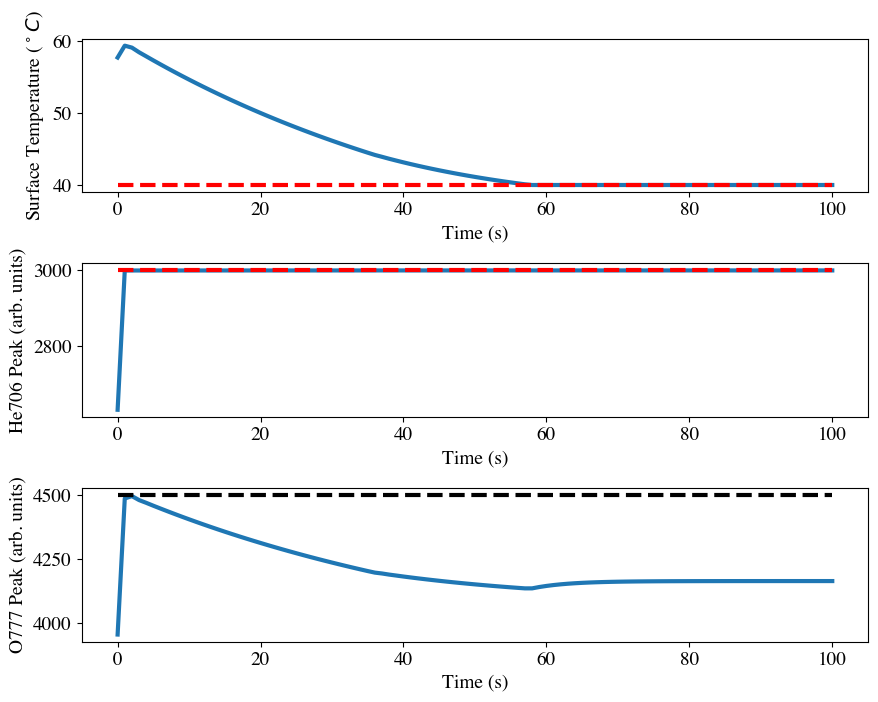

In [11]:
fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(411)
#ax.plot(np.arange(len(dose_plot))*ts, Yrefplot, 'k--', label='Reference')
#ax.plot(np.arange(len(dose_plot))*ts, dose_plot)
#ax.set_xlabel('Time (s)')
#ax.set_ylabel('Thickness')

ax = fig.add_subplot(311)
#ax.axhline(x_max[0]+xss[0], color='r', ls='--', label='Maximum')
ax.plot(np.arange(len(Tplot))*ts, Tplot)
ax.plot(np.arange(len(Tplot))*ts, Yrefplot2, 'r--', label='Reference')
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Surface Temperature ($^\circ C$)')

ax = fig.add_subplot(312)
#ax.set_yticks(np.arange(1000,6000,1000))
ax.plot(np.arange(len(I706))*ts, I706)
ax.plot(np.arange(len(I706))*ts, Yrefplot, 'r--', label='Reference')
ax.set_xlabel('Time (s)')
ax.set_ylabel('He706 Peak (arb. units)')

ax = fig.add_subplot(313)
#ax.set_yticks(np.arange(1000,6000,1000))
ax.plot(np.arange(len(I777))*ts, I777)
constr_plot = np.ones(len(I777))*4500
ax.plot(np.arange(len(I777))*ts, constr_plot, 'k--', label='Reference')
ax.set_xlabel('Time (s)')
ax.set_ylabel('O777 Peak (arb. units)')
plt.tight_layout()
plt.draw()



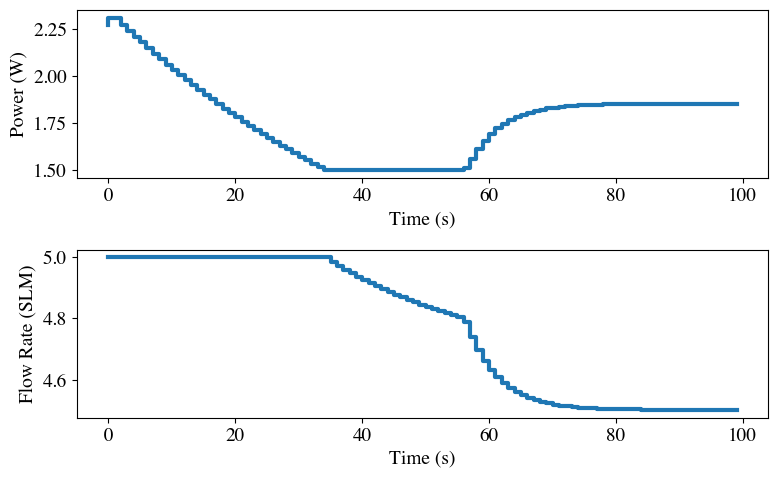

In [12]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(211)
#ax1.set_yticks(np.arange(1,6))
ax1.step(np.arange(st-1)*ts, sim_data['Usim'][0,:(st-1)]+ussp[0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Power (W)')

ax2 = fig.add_subplot(212)
#ax2.set_yticks(np.arange(1,7))
ax2.step(np.arange(st-1)*ts, sim_data['Usim'][1,:(st-1)]+ussp[1])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Flow Rate (SLM)')
plt.tight_layout()
plt.draw()

plt.show()

##### href = 4500 deleting the lines of the economic mpc and get mpc from the simulator.py

In [16]:
sim_data['Usim'][0,:(st-1)]+ussp[1]

array([5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000001,
       5.00000001, 5.00000001, 5.00000001, 5.00000001, 5.00000